# Cel zadania

Celem zadania było wykonanie eksperymentu polegającego na przetestowaniu jak wielkość dopełniennia Shura wpływa na czas wykonania algorytmu obliczające faktoryzacje Cholesky'ego.

# Wybór macierzy

Wybór macierzy kako macierze testowe wybraliśmy blokowe macierze powstałe z macierzy typu
IGA i FEM, wygenerowane za pomocą dołączonego skryptu w zestawie zadania (uzywając funkcji
`massmatrix`, z parametrami  `riga`=$0/1$, `pxx`=$2$, `rxx`=$0$, `nxx`=$7$). Macierze bazowe mają rozmiar $81 × 81$, macierze
wynikowe powstały poprzez zwielokrotnienie bazowych macierzy kolejno 1, 2, 5, 10 i 20 razy (co daje ostatecznie macierze $81\times81$, $162\times162$, $405\times405$, $810\times810$ i $1620\times1620$ ).

# Wybór wielkości dopełnień Shura
Dla zadanych macierzy przetestowaliśmy dopełnienia Shura o wielkości kolejno $\frac{n}{2} \times \frac{n}{2} $, $\frac{n}{4} \times \frac{n}{4} $, $\frac{n}{8} \times \frac{n}{8} $, $\frac{n}{16} \times \frac{n}{16} $, $\frac{n}{32} \times \frac{n}{32} $ oraz dla sytuacji, gdzie nie ma zadanego dopełnienia.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [131]:
def load_base_matrix(riga,nxx,pxx,rxx):  
    return np.genfromtxt(f'mat_{riga}.csv', delimiter=',') 
    
def generate_matrix(riga,nxx,pxx,rxx):
    t = load_base_matrix(riga,nxx,pxx,rxx)
    return np.block([[t] * nxx] * nxx)

# Program wykonywujący faktoryzacje

Moduł wykonujący faktoryzacje został napisany w języku Python, z uzyciem biblioteki numerycznej NumPy. W implementacji algorytmu wykorzystaliśmy operacje wektorowe, w celu minimalizacji "złozoności pamięciowej" algorytmu. Algorytm działa "in place" tzn. wynik końcowy jest zapisywany w macierzy wejściowej, w części odpowiadającej macierzy trójkątnej dolnej. Pozostałe komórki macierzy nie zostały przez nas wyzerowane, uznaliśmy, ze nie jest to warunek konieczny przy testowaniu algorytmu. Dodatkowo algorytm posiada dodatkowy parametr wejściowy `block_size`, umozliwiający obliczenie dopełnienia Shura o zadanej wielkości (co efektywnie obniza liczbe wykonywanych operacji).


In [19]:
def cholesky(A, block_size=0):
    n = len(A)
    block_size = n - block_size
    for k in range(block_size):
        A[k, k] = np.sqrt(A[k, k])
        A[k+1:n, k] /= A[k, k]
        vk = A[k+1:n, k].flatten()
        for j in range(k + 1, n):
            A[j:n, j] -= A[j:n, k] * vk[j - (k + 1)]
    return A

## Złozonosci obliczeniowe

Wliczamy kolejno
 - operacje pierwiastkowania $F(1)$
 - operacje dzielenia $F(n-k-1)$
 - operacje mnozenia $F(n - j)$
 - operacje odejmowania $F(n-j)$

Co daje wzór (gdzie $n \times n$ to rozmiar macierzy, $m \times m$ to rozmiar dopełnienia Shura):

$F(n, m) = \sum_{k=0}^{n-1-m} (1 + (n-k-1) + \sum_{j=k+1}^{n-1}2\cdot(n - j))$

$F(n, m) = \sum_{k=0}^{n-1-m} (1 + (n-k-1) + (n - k - 1)(n-k))$

$F(n, m) = \sum_{k=0}^{n-1-m} (1 + (n - k - 1)(n - k +1))$

$F(n, m) = \sum_{k=0}^{n-1-m} (1 + (n - k)^2 - 1)$

$F(n, m) = \sum_{k=0}^{n-1-m} ((n - k)^2)$

$F(n, m) = \frac{1}{6} \cdot (n-m)(6n^2-6n(m-n-1) + 2(m-n-1)^2 + m-n-1)$

## Złozoność pamięciowa
Biblioteka NumPy przechowuje macierze w sposób wierszowy. Wersja kolumnowa algorytmu odczytuje sekwencyjnie kolumny macierzy, co powoduje, ze kazda operacja odczytu (nawet sekwencyjnego) jest liniowo proporcjonalna do liczby elementów. Jedynym wyjątkiem jest odczyt z z pomocniczego wektora `vk`, który jest jednostkowy.

Wliczamy kolejno
 - operacje odczytu $A(k, k)$&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;-$M(1)$
 - operacje odczytu $A(k+1:n, k)$&emsp;&emsp;-$M(n-k-1)$
 - operacje odczytu $A(j:n, j)$&emsp;&emsp;&emsp;&emsp;-$M(n - j)$
 - operacje odczytu $A[j:n, k]$&emsp;&emsp;&emsp;&emsp;-$M(n - j)$
 - operacje odczytu $vk(j - (k + 1))$&emsp;-$M(1)$

Ostatecznie wzór na zloznosc pamieciąwą jest taki sam, jak dla złozonosci obliczeniowej.

$M(m, n) = \sum_{k=0}^{n-1-m} (1 + (n-k-1) + \sum_{j=k+1}^{n-1}2\cdot(n - j))$

$M(m, n) = \frac{1}{6} \cdot (n-m)(6n^2-6n(m-n-1) + 2(m-n-1)^2 + m-n-1)$

# Testy

Testy zostały wykonane na kazdej macierzy, dla kazdej wielkości dopełnienia Shura. Dla kazdego przypadku testy trwały przynajmniej 2 sekundy, z danych prób była następnie wyciągana średnia.


In [137]:
import timeit
import math
def test_cholesky(parameters, block_prop=0, min_time=2):
    riga, pxx, rxx, nxxs = parameters
    ns, ts = [], []
    for nxx in nxxs:
        tries = 0
        t_sum = 0
        while t_sum < min_time:    
            A = generate_matrix(riga, nxx, pxx, rxx)
            n = A.shape[0]
            block_size = math.floor(n * block_prop)
            f = lambda: cholesky(A, block_size)
            t = timeit.timeit(f, number=1)
            t_sum += t
            tries += 1
        ts.append(t_sum / tries)
        ns.append(n)
        
    return ns, ts  

In [128]:
def measure_times(parameterss, matrices, blocks_props):
    results = []
    for parameters, matrix in zip(parameterss, matrices):
        for block_prop in blocks_props:
            ns, ts = test_cholesky(parameters, block_prop, 2)
            for n, t in zip(ns, ts):
                results.append([matrix, block_prop, n, t])
    results = pd.DataFrame(data=results, columns=['matrix', 'prop', 'size', 'time'])
    results.set_index(['matrix', 'prop', 'size'], inplace=True)
    return results

In [138]:
blocks_props = [1/2, 1/2**2, 1/2**3, 1/2**4, 1/2**5, 0]
parameterss = [(0, 2, 0, [1, 2, 5, 10, 20]), (1, 2, 0, [1, 2, 5, 10, 20])]
matrices = ['IGA', 'FEM']

results = measure_times(parameterss, matrices, blocks_props)

C:\Users\Private\AppData\Local\Temp/ipykernel_2528/1721594309.py:5: RuntimeWarning: invalid value encountered in sqrt
  M[k, k] = np.sqrt(M[k, k])


In [201]:
def plot_results_for_matrix(matrix, results, ax=None, xscale='linear', yscale='linear', title=''):
    # if ax is None:
    #     fig, ax = plt.subplots(figsize=(10, 10))
    all_ns = set()


    for prop in blocks_props:
        res = results.loc[matrix, prop, :]
        ns = res.index.get_level_values(-1).to_numpy()
        ts = res['time'].to_numpy()

        ns //= 49
        ns *= 81
        ts *= 2.3 if matrix == 'IGA' else 2.1
        

        if prop == 0:
            label = 'Brak dopełnienia Shura'
        else:
            k = int(1/prop)
            label = f'Wielkość dopełnienia Szhura $\\frac{{n}}{{{k}}} \\times \\frac{{n}}{{{k}}}$'
        ax.scatter(ns, ts, label=label)
        ax.plot(ns, ts, '--')
        all_ns = all_ns | set(ns)

    ax.set_xlabel(r'Wielkość macierzy $n \times n$', fontsize = 20)
    ax.set_ylabel(r'Czas wykonania dekompozycji [s]', fontsize = 20)

    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    ax.set_title(title, fontsize = 20)
    

    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.legend(fontsize=14)
    ax.grid()
    ax.set_xticks(list(sorted(list(all_ns))))
    ax.set_xticklabels(list(sorted(list(all_ns))), rotation='30')

In [203]:
def plot_results_for_matrix_in_both_scales(matrix):
    fig, (ax_lin, ax_log) = plt.subplots(1, 2, figsize =(20 ,10))
    plot_results_for_matrix(matrix, results, ax=ax_lin, title = 'Skala liniowa')
    plot_results_for_matrix(matrix, results, ax=ax_log, yscale='log', title = 'Skala logarytmiczna')
    title = f"""\nCzasy wykonania dekompozycji Cholesky'ego metodą kolumnową dla macierzy {matrix}
        dla poszczególnych wielkości macierzy i róznych wielkości dopełnień Shura\n"""
    fig.suptitle(title, fontsize = 30)
    fig.tight_layout()
    plt.show()

# Wykresy

## Macierz IGA

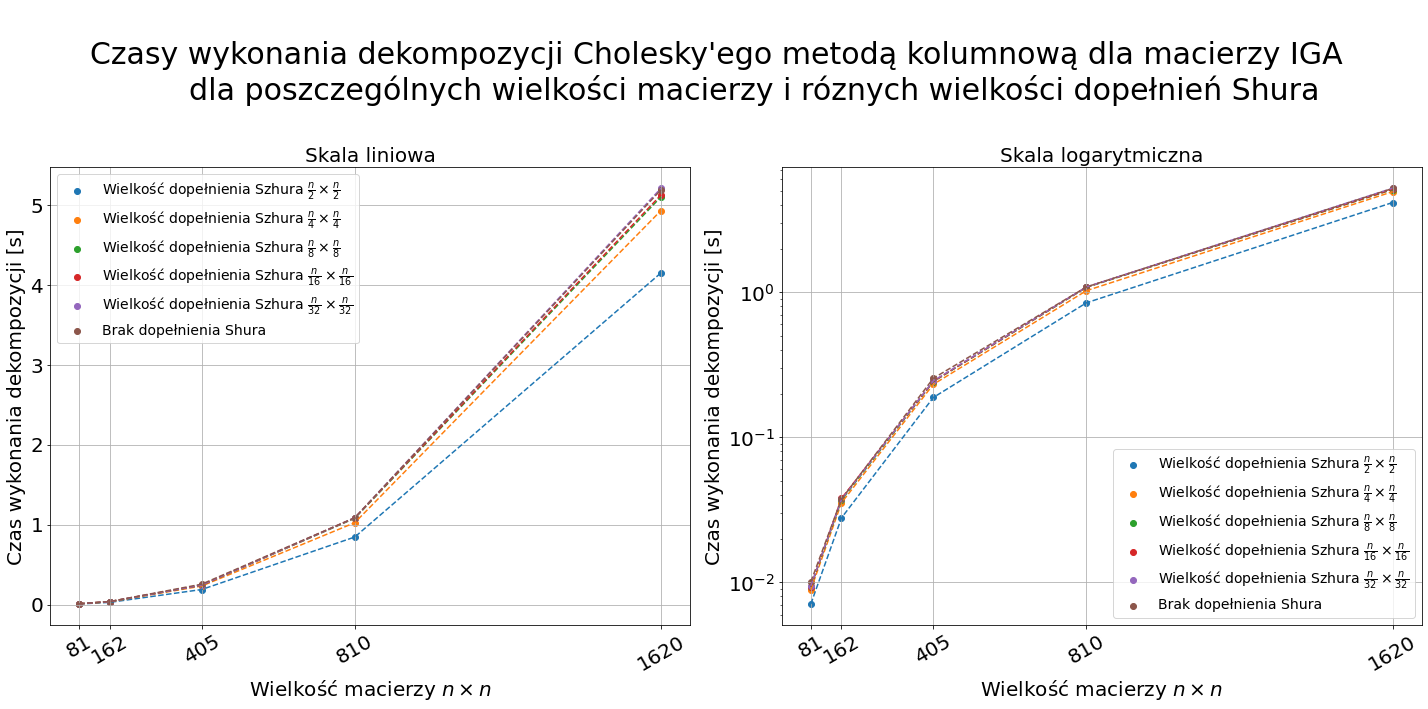

In [208]:
plot_results_for_matrix_in_both_scales("IGA")

## Macierz FEM

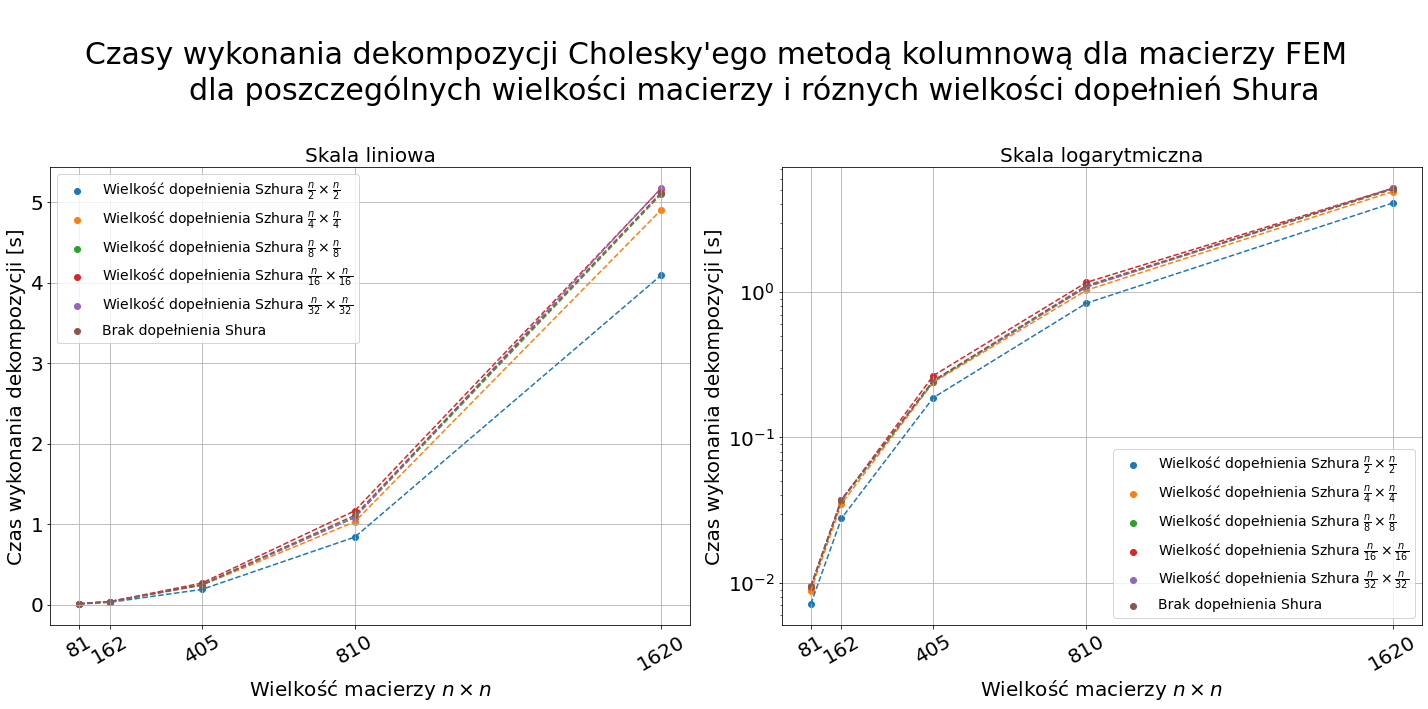

In [209]:
plot_results_for_matrix_in_both_scales("FEM")

# Wnioski

Udało się nam poprawnie wykonać wszystkie zaplanowane punkty zadania.
Dla zadanych macierzy udało się nam pokazać złozoność kubiczną, dla zadanego algorytmu. Niestety, z powodu nie dopasowania wersji algorytmu do reprezentacji macierzy złozonosc pamięciowa tez okazala sie byc tego rzędu.

Dodatkowo, jak zostało pokazane na wykresach, wielkość dopełnienia Shura miała głównie znaczenie dla bloku wielkości $\frac{n}{2} \times \frac{n}{2}$ i $\frac{n}{4} \times \frac{n}{4}$. Procent liczby operacji, jaki trzeba wykonac wzgledem proporcji bloku do macierzy mozna przyblizyc wzorem $1 - p^2$, co pokazuje, ze dla $p=\frac{1}{2}$ musimy wykonać około $75\%$ obliczeń, dla $p=\frac{1}{4}$ około $94\%$, i dla kolejnych, coraz mniejszych wartości $p$ wartość ta bardzo szybko zbliza się do $100%$, co dobrze oddają wykresy.